In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import data
import numpy as np

g = data.get_gaps()
s = data.get_synapses()
conn_g = np.argwhere(g.values > 0)
conn_s = np.argwhere(s.values > 0)

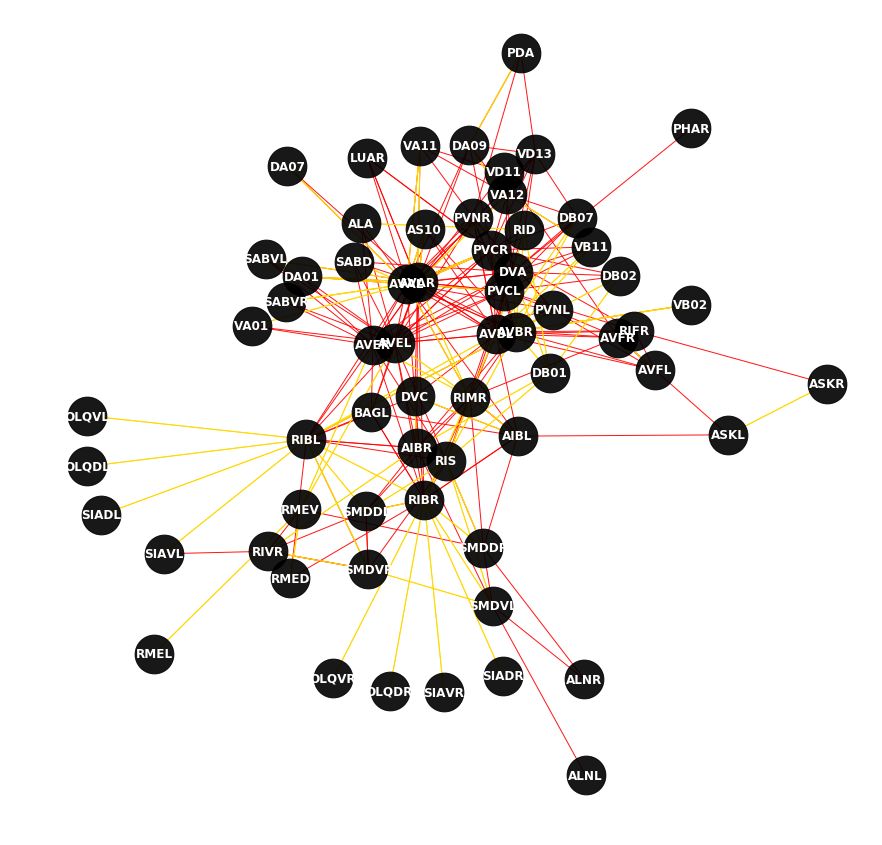

In [12]:

import sys
sys.path.insert(0, '..')
from odynn.circuit import Circuit
from odynn.models import LeakyIntegrate, ChemSynTau, GapJunctionTau
import numpy as np
import torch

DT = 0.25
N_parallel = 50

def get_circ():
    n = LeakyIntegrate.create_default(64, N_parallel, tensors=True, dt=DT)
    ps = ChemSynTau.get_random(len(conn_s),N_parallel)
    s = ChemSynTau([c[0] for c in conn_s], [c[1] for c in conn_s], 
                              init_p=ps, tensors=True, dt=DT)
    pg = GapJunctionTau.get_random(len(conn_g),N_parallel)
    g = GapJunctionTau([c[0] for c in conn_g], [c[1] for c in conn_g], 
                              init_p=pg, tensors=True, dt=DT)
    return Circuit(n, s, g)


get_circ().plot(labels={i: data.NAMES[i] for i in range(64)})

In [13]:
import pylab as plt
from odynn import optim

traces_orig = data.get_data()
# plt.plot(traces_orig.values[:400])
traces = traces_orig.values[:100]
traces = np.repeat(traces, 4, axis=0)
traces = torch.Tensor(traces[:,None,None,:,None])
traces = traces.expand(list(traces.shape[:-1]) + [N_parallel])
target = optim.corr(traces)
print(traces.shape, target.shape)

# test
# a = torch.rand((200,1,1,64,5))
# print(loss(a))
    

torch.Size([400, 1, 1, 64, 50]) torch.Size([64, 64, 50])


(400, 64)


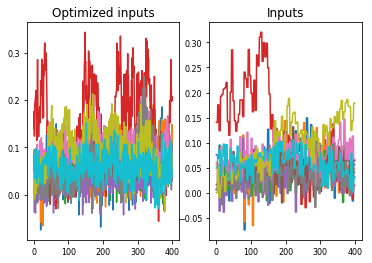

(420, 64)


In [21]:
import pickle

with open('currents', 'rb') as f:
    sensors, inputs, n_par = pickle.load(f)
    
plt.subplot(121)
plt.plot(inputs)
plt.title('Optimized inputs')

# FLOAT !!!!!!!!!!!!!
inj = np.full((traces.shape[0], traces.shape[3]), 0.)
print(inj.shape)

sensors_idx = []
for i, n in enumerate(sensors):
    idx = list(traces_orig.columns).index(n)
    sensors_idx.append(idx)
#     inj[0:2,idx]=[4,5]
    inj[:,idx] = np.repeat(inputs[:100,i], 4, axis=0)
#     inj[:,idx] = inputs[:,i]
    
# inj = np.repeat(inj, 4, axis=0)
    
plt.subplot(122)
plt.title('Inputs')
plt.plot(inj[:, sensors_idx])
plt.show()

injstab = np.zeros(inj.shape)
injstab = injstab[:20]
inj = np.concatenate((injstab, inj))
print(inj.shape)







  0%|          | 0/501 [00:00<?, ?it/s]

torch.Size([1, 1, 64, 50])
Initial states shape :  torch.Size([1, 1, 64, 50]) Input current shape :  torch.Size([420, 1, 64, 50])
936.30804 671.4191


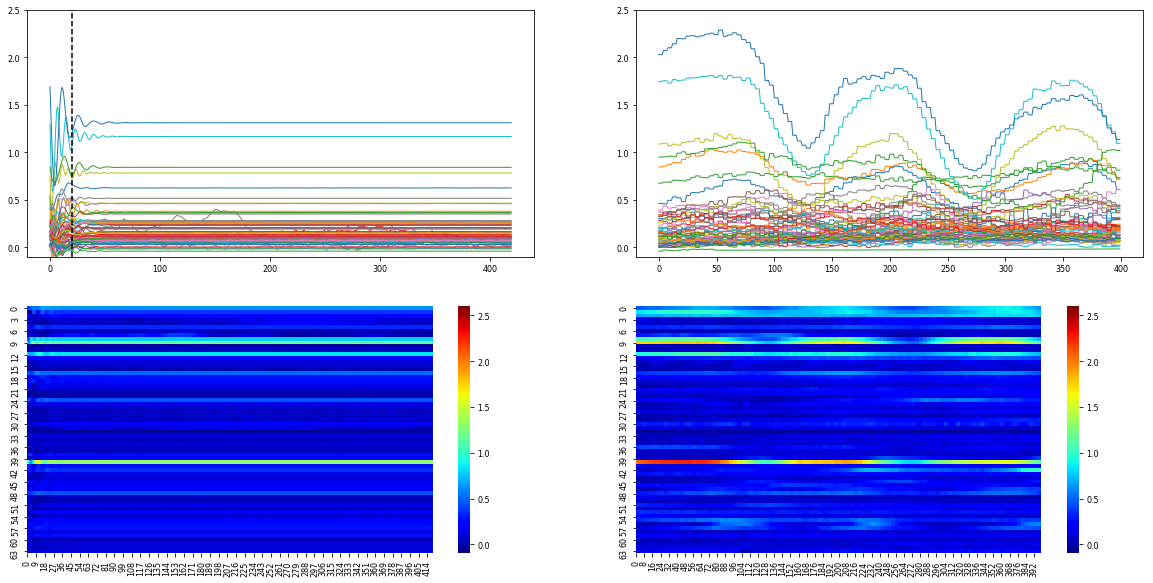







  0%|          | 1/501 [00:37<5:09:38, 37.16s/it]

Initial states shape :  torch.Size([1, 1, 64, 50]) Input current shape :  torch.Size([420, 1, 64, 50])
895.11835 646.48627


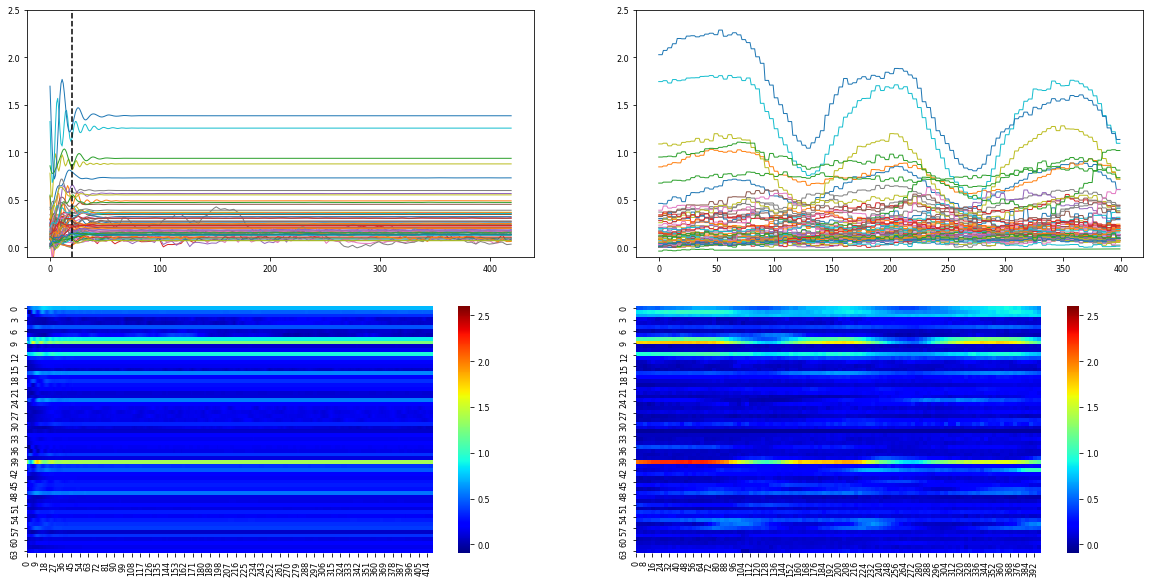







  0%|          | 2/501 [01:17<5:16:23, 38.04s/it]

Initial states shape :  torch.Size([1, 1, 64, 50]) Input current shape :  torch.Size([420, 1, 64, 50])
839.86127 617.8594


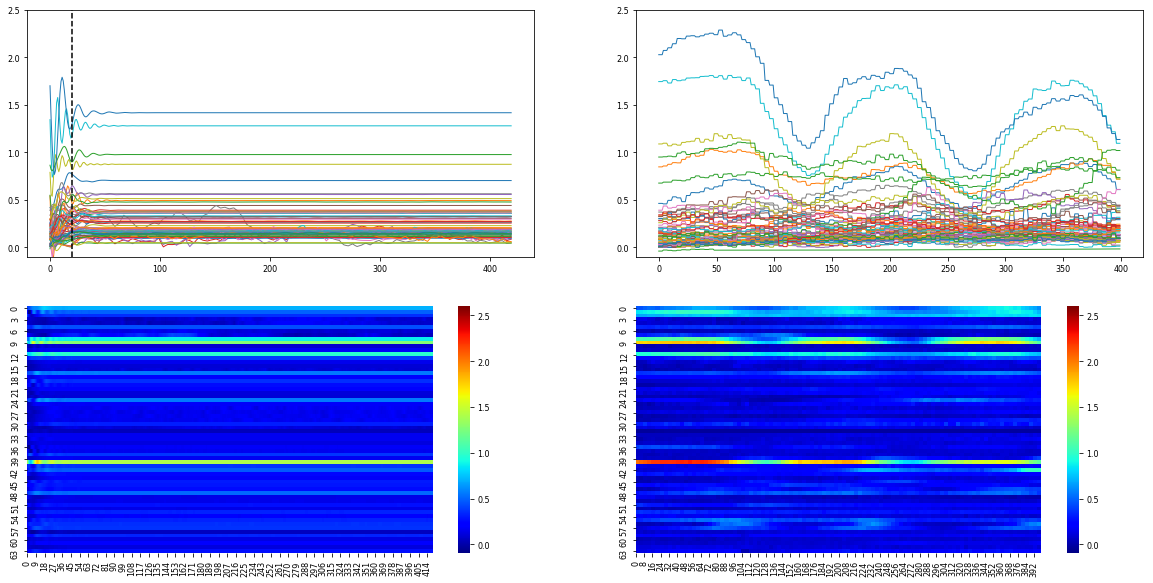







  1%|          | 3/501 [01:52<5:07:54, 37.10s/it]

Initial states shape :  torch.Size([1, 1, 64, 50]) Input current shape :  torch.Size([420, 1, 64, 50])


In [ ]:
from tqdm import tqdm
import seaborn as sns

init = traces[0]
print(init.shape)

"""Optimize correlation"""


# circuit = get_circ()
# circuit._neurons._param = n_par
# circuit._gaps.tau = 20
# circuit._synapses.tau = 20
params = list(circuit._synapses.parameters.values()) + list(circuit._gaps.parameters.values())

def plots(y, traces, loss):
    plt.figure(figsize=(20,10))
    print(loss.mean().detach().numpy(), loss.min().detach().numpy())
    best = loss.argmin()
    plt.subplot(221)
    plt.plot(y[:,0,0,:,best].detach().numpy(), linewidth=1)
    plt.axvline(20, color='k', linestyle='--')
    plt.ylim([-0.1, 2.5])
    plt.subplot(222)
    plt.plot(traces[:,0,0,:,best].detach().numpy(), linewidth=1)
    plt.ylim([-0.1, 2.5])
    plt.subplot(223)
    sns.heatmap(y[:,0,0,:,best].detach().numpy().T, cmap='jet', vmin=-0.1, vmax=2.6)
    plt.subplot(224)
    sns.heatmap(traces[:,0,0,:,best].detach().numpy().T, cmap='jet', vmin=-0.1, vmax=2.6)
    plt.show()
    plt.close()

opt, losses = optim.optim(circuit, params, inj, optim.loss_mse, traces, plot_func=plots, 
                          plot_period=1, init=init, n_epochs=501)
        

plt.plot([l.detach().numpy() for l in losses], linewidth=0.2)
plt.yscale('log')
plt.show()

In [ ]:
print(circuit.parameters)